# Fairness Exemplo 1

Ideia: Criar um Modelo de Predição simples a partir da base de dados "adult.csv" e checar de alguma forma se a restrição de independência está sendo cumprida para o atributo sensível RAÇA.

Independência: P{R = 1; A = a} = P{R = 1; A = b}; Para todo grupo a e b

Primeiro vou fazer um modelo simples, só inserindo tudo. Aparentemente a base já veio com tratamento de nulos, então provavelmente já foi feito um pré-processamento.

Importando as bibliotecas principais e recebendo os dados.

In [123]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv("C:\\Users\\murilo.pinheiro\\Documents\\Notebooks\\adult.csv")
data = data.drop(data.loc[data['native-country'] == 'Holand-Netherlands'].index, axis = 0)
data = data.drop('native-country', axis = 1)
data = data.drop('education', axis = 1) # excluindo isso pq já temos a equivalente numérica educational-num
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48841 entries, 0 to 48841
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48841 non-null  int64 
 1   workclass        48841 non-null  object
 2   fnlwgt           48841 non-null  int64 
 3   educational-num  48841 non-null  int64 
 4   marital-status   48841 non-null  object
 5   occupation       48841 non-null  object
 6   relationship     48841 non-null  object
 7   race             48841 non-null  object
 8   gender           48841 non-null  object
 9   capital-gain     48841 non-null  int64 
 10  capital-loss     48841 non-null  int64 
 11  hours-per-week   48841 non-null  int64 
 12  income           48841 non-null  object
dtypes: int64(6), object(7)
memory usage: 5.2+ MB


Separando os dados entre X e Y, onde Y é a variável alvo.
Após isso faço um split para termos os dados de teste e os de treino. Fixo um random_state para checar melhor os resultados.

In [124]:
x = data.drop(['income'], axis=1)
Y = data["income"]

from sklearn.model_selection import train_test_split

x_train, x_test, Y_train, Y_test = train_test_split(x, Y, test_size = 0.3)
x_test.head()

,age,workclass,fnlwgt,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week
28856,38,Self-emp-inc,269318,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,7298,0,40
43406,72,Private,107814,14,Never-married,Prof-specialty,Not-in-family,White,Male,2329,0,60
43251,17,Private,271122,8,Never-married,Other-service,Own-child,White,Female,0,0,16
43616,37,Private,172722,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40
21977,31,Local-gov,381153,10,Married-civ-spouse,Protective-serv,Husband,White,Male,15024,0,56


Utilizo um Ordinal Encoder em todas as minhas variáveis categóricas presente em X, tanto em X-Treino como X-Teste.
Após fazer isso, eu faço uma coisa parecida com a variável alvo, basicamente torno ela um valor binário(1 ou 0).

In [125]:
from sklearn.preprocessing import OneHotEncoder

categoricalLabels = (x_train.select_dtypes(include = ['object'])).columns

print(categoricalLabels)

encoder = OneHotEncoder(handle_unknown='ignore', sparse = False, categories = "auto")
OHtrain = pd.DataFrame(encoder.fit_transform(x_train[categoricalLabels]))
OHtest = pd.DataFrame(encoder.transform(x_test[categoricalLabels]))

OHtrain.index = x_train.index
OHtest.index = x_test.index

old_x_train = x_train[categoricalLabels]
old_x_test = x_test[categoricalLabels]

num_x_train = x_train.drop(categoricalLabels, axis = 1)
num_x_test = x_test.drop(categoricalLabels, axis = 1)

num_x_train = pd.concat([num_x_train, OHtrain], axis = 1)
num_x_test = pd.concat([num_x_test, OHtest], axis = 1)

num_Y_test = Y_test.apply(lambda p: 1 if p == '>50K' else 0)
num_Y_train = Y_train.apply(lambda p: 1 if p == '>50K' else 0)
num_x_test.head()

Index(['workclass', 'marital-status', 'occupation', 'relationship', 'race',
       'gender'],
      dtype='object')


,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,0,1,2,3,...,34,35,36,37,38,39,40,41,42,43
28856,38,269318,10,7298,0,40,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
43406,72,107814,14,2329,0,60,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
43251,17,271122,8,0,0,16,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
43616,37,172722,10,0,0,40,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
21977,31,381153,10,15024,0,56,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


# Classificador (Árvore de Decisão) 
Após isso, faço o modelo propriamente dito, utilizo um Classificador de Árvore de decisão e efetuo a predição, fixo um random_state para ter o mesmo MAE, mas o valor do MAE é cerca de 0.18, variando um pouco pra mais ou pra menos.

In [126]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error

modelo = DecisionTreeClassifier()

modelo.fit(num_x_train, num_Y_train)
previsao = modelo.predict(num_x_test)

acuraciaNP = mean_absolute_error(num_Y_test, previsao)
print(acuraciaNP)

c:\Users\murilo.pinheiro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


0.18528628949703133


c:\Users\murilo.pinheiro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Aqui vem a parte final. Checar a independência, como não sei uma forma de quantificar tudo isso resolvi fazer essa checagem por meio de gráficos. Um gráfico que mostra a proporção de pessoas que são classificadas, como positivas ou negativas, separadas por raça.

Primeiro eu inverto a transformação feita antes nas variáveis categóricas, após isso eu junto o X-Teste com a Previsão com os valores de Ŷ, que são os Y's do Classificador.
Após isso eu seleciono apenas os Atributos Raça e o Ŷ. Depois eu agrupo os dados a partir do Ŷ e conto os valores separados por raça.
Com isso, eu conto os valores apenas por Raça, para saber quantas pessoas eu tenho de cada Raça. Então eu faça uma Junção para ter um registro formado por:

Ŷ - Raça - Quantidade de Ŷ para aquela raça - Quantidade de Pessoas daquela raça.

OBS: Não sei se fazer essa junção era a maneira mais fácil de fazer o que eu fiz, mas foi a única que lembrei como fazer, talvez encontre uma forma melhor e mais rápida depois.

Para finalizar eu reverto a codificação binária que fiz no Y, e obtenho a Proporção de Ŷ para aquela raça a partir de:

(Quantidade de Ŷ para aquela raça) / (Quantidade de Pessoas daquela raça).

In [127]:
df = num_x_test.copy()
print(df.head())
v = np.arange(44)
df = df.drop(v, axis = 1)
print(df.head())
df[categoricalLabels] = old_x_test
df["income"] = previsao
df = df[["race", "income"]]
hue = "income"
print(df.head())
dfe = pd.DataFrame(df.groupby('income').value_counts().rename("count").reset_index())

dfd = df["race"].value_counts()
dfd = dfd.reset_index()
dfe = dfe.merge(dfd, left_on='race', right_on='index')
dfe = dfe.drop("index", axis = 1)

dfe = dfe.rename(columns = {"race_x": "race", "race_y": "total"})
dfe["proportion"] = dfe["count"]/dfe["total"]*100

dfe['income'] = dfe["income"].apply(lambda p: '>50K' if p == 1 else '<=50K')



       age  fnlwgt  educational-num  capital-gain  capital-loss  \
28856   38  269318               10          7298             0   
43406   72  107814               14          2329             0   
43251   17  271122                8             0             0   
43616   37  172722               10             0             0   
21977   31  381153               10         15024             0   

       hours-per-week    0    1    2    3  ...   34   35   36   37   38   39  \
28856              40  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0   
43406              60  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0   
43251              16  0.0  0.0  0.0  0.0  ...  1.0  0.0  0.0  0.0  0.0  0.0   
43616              40  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0   
21977              56  0.0  0.0  1.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0   

        40   41   42   43  
28856  0.0  1.0  0.0  1.0  
43406  0.0  1.0  0.0  1.0  
43251  0.0  1.0  1.0  0.0  
4361

# Classificador (Árvore de Decisão) Protegido
A Partir daqui repito os passos para o Modelo Protegido

In [128]:
encoder2 = OneHotEncoder(dtype = "int32", handle_unknown='ignore', sparse = False, categories = "auto")

num_x_testProtected = x_test.copy()
num_x_trainProtected = x_train.copy()

raceTest = num_x_testProtected["race"]
num_x_testProtected = num_x_testProtected.drop(["race"], axis = 1)
num_x_trainProtected = num_x_trainProtected.drop(["race"], axis = 1)

categoricalLabelsProtected = (num_x_testProtected.select_dtypes(include = ['object'])).columns

OHtrainProtected = pd.DataFrame(encoder2.fit_transform(num_x_trainProtected[categoricalLabelsProtected]))
OHtestProtected = pd.DataFrame(encoder2.transform(num_x_testProtected[categoricalLabelsProtected]))

OHtrainProtected.index = num_x_trainProtected.index
OHtestProtected.index = num_x_testProtected.index

old_x_trainProtected = num_x_trainProtected[categoricalLabelsProtected]
old_x_testProtected = num_x_testProtected[categoricalLabelsProtected]

num_x_trainProtected = num_x_trainProtected.drop(categoricalLabelsProtected, axis = 1)
num_x_testProtected = num_x_testProtected.drop(categoricalLabelsProtected, axis = 1)

num_x_trainProtected = pd.concat([num_x_trainProtected, OHtrain], axis = 1)
num_x_testProtected = pd.concat([num_x_testProtected, OHtest], axis = 1)

num_Y_testProtected = Y_test.apply(lambda p: 1 if p == '>50K' else 0)
num_Y_trainProtected = Y_train.apply(lambda p: 1 if p == '>50K' else 0)
#Não era preciso fazer isso porquê já foi feito antes mas vou refazer por via das Dúvidas e para não confundir

In [129]:
modeloProtected = DecisionTreeClassifier()

modeloProtected.fit(num_x_trainProtected, num_Y_trainProtected)
previsaoProtected = modeloProtected.predict(num_x_testProtected)

acuraciaP = mean_absolute_error(num_Y_testProtected, previsaoProtected)
print(acuraciaP)

c:\Users\murilo.pinheiro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


0.18296594554016243


c:\Users\murilo.pinheiro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [130]:
dfProtected = num_x_testProtected.copy()
print(num_x_testProtected)
v = np.arange(44)
dfProtectedmain = num_x_testProtected.drop(v, axis = 1)
dfProtectedmain[categoricalLabelsProtected] = old_x_testProtected
dfProtectedmain["income"] = previsaoProtected
dfProtectedmain["race"] = raceTest
dfProtected = dfProtectedmain[["race", "income"]]
hue = "income"

dfeProtected = pd.DataFrame(dfProtected.groupby('income').value_counts().rename("count").reset_index())

dfdProtected = dfProtected["race"].value_counts()
dfdProtected = dfdProtected.reset_index()
dfeProtected = dfeProtected.merge(dfdProtected, left_on='race', right_on='index')
dfeProtected = dfeProtected.drop("index", axis = 1)

dfeProtected = dfeProtected.rename(columns = {"race_x": "race", "race_y": "total"})
dfeProtected["proportion"] = dfeProtected["count"]/dfeProtected["total"]*100

dfeProtected['income'] = dfeProtected["income"].apply(lambda p: '>50K' if p == 1 else '<=50K')

       age  fnlwgt  educational-num  capital-gain  capital-loss  \
28856   38  269318               10          7298             0   
43406   72  107814               14          2329             0   
43251   17  271122                8             0             0   
43616   37  172722               10             0             0   
21977   31  381153               10         15024             0   
...    ...     ...              ...           ...           ...   
38155   51   95946               13             0             0   
21929   45   67544               14             0             0   
20167   35  361888               12             0             0   
47696   39  314822               10             0             0   
47984   30  345522                9          3103             0   

       hours-per-week    0    1    2    3  ...   34   35   36   37   38   39  \
28856              40  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0   
43406              60  0.0  0.0  0.

### Restrição de "Statistical Parity"
Checagem da Restrição de Paridade Estatística para esse Modelo.

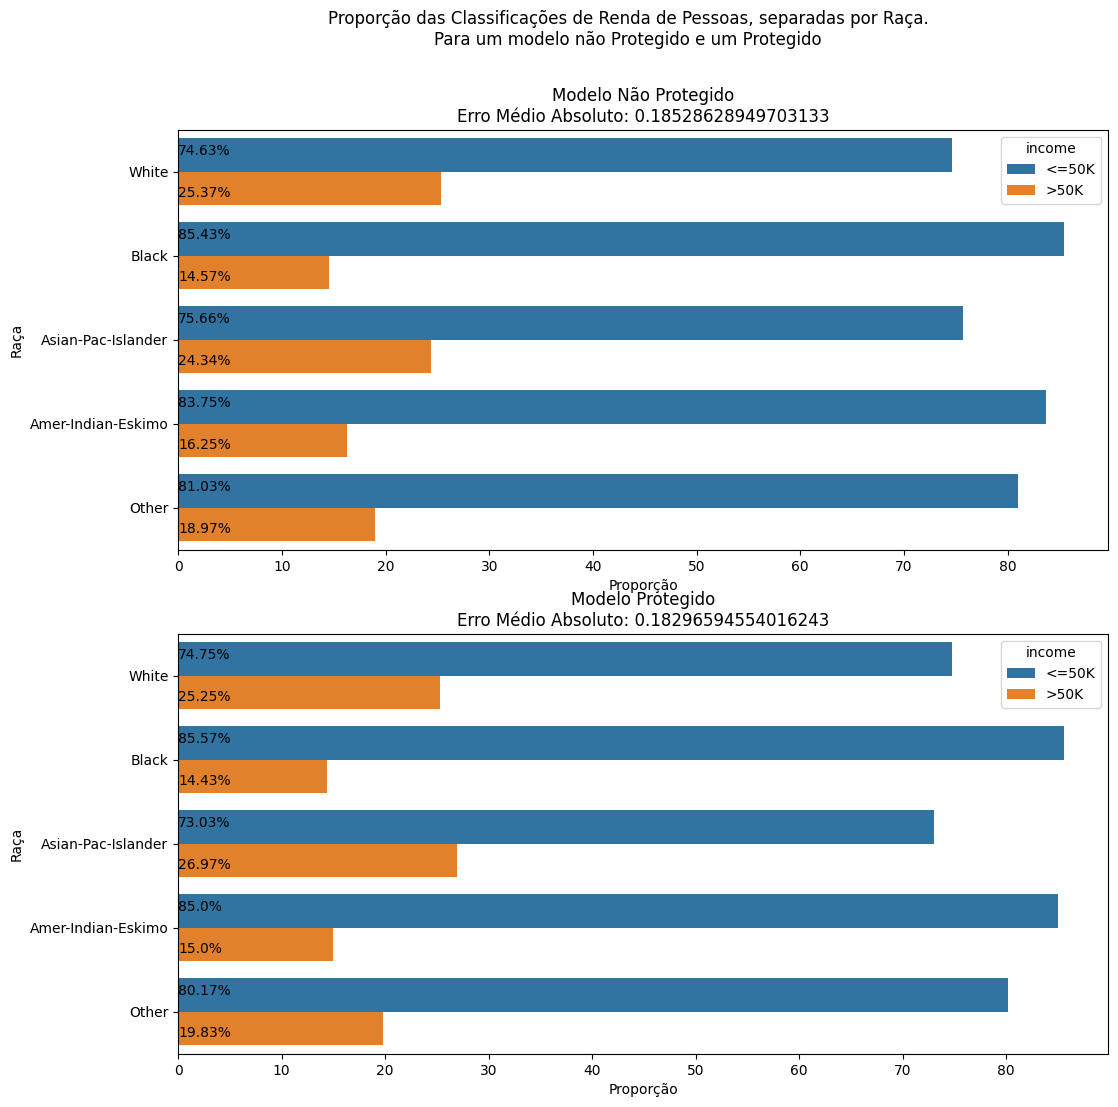

In [131]:
fig, ax = plt.subplots(2, 1, figsize = (12, 12))
fig.suptitle("Proporção das Classificações de Renda de Pessoas, separadas por Raça.\nPara um modelo não Protegido e um Protegido")

plot = sns.barplot(ax = ax[0], data = dfe,x = "proportion", y = "race", hue = "income")
plot.set_ylabel("Raça")
plot.set_xlabel("Proporção")

for index, row in dfe.iterrows():
    plot.text(0, (row.name)/2 - 0.2, str(round(row.proportion, 2)) + "%",color='black')
    
plot1 = sns.barplot(ax = ax[1], data = dfeProtected,x = "proportion", y = "race", hue = "income")
plot1.set_ylabel("Raça")
plot1.set_xlabel("Proporção")

for index, row in dfeProtected.iterrows():
    plot1.text(0, (row.name)/2 - 0.2, str(round(row.proportion, 2)) + "%",color='black')

ax[0].set_title("Modelo Não Protegido\nErro Médio Absoluto: " + str(acuraciaNP))
ax[1].set_title("Modelo Protegido\nErro Médio Absoluto: " + str(acuraciaP))
plt.show()
fig.savefig("output1.png")

### Restrição de "Equalized Odds"

In [132]:
newdata = pd.DataFrame()
newdata['race'] = raceTest.copy()
newdata['previsao'] = previsaoProtected.copy()
newdata['income'] = num_Y_testProtected.copy()

In [133]:
races = newdata['race'].unique()
tabela = pd.DataFrame(columns = ['Race', 'Valor', 'Tipo'])

for race in races:
    groupedRaces = (newdata.loc[(newdata['race'] == race)])
    crosstab = pd.crosstab(groupedRaces['previsao'], groupedRaces['income'], margins = True)

    valor = crosstab.iloc[0,0]/crosstab.iloc[2,0]
    valor2 = crosstab.iloc[1,1]/crosstab.iloc[2,1]

    tabela.loc[-1] = [race, valor, 'Rejeitado']
    tabela.index = tabela.index + 1
    tabela = tabela.sort_index()
    tabela.loc[-1] = [race, valor2, 'Aceitado']
    tabela.index = tabela.index + 1
    tabela = tabela.sort_index()

tabela['Valor'] = tabela['Valor'] * 100

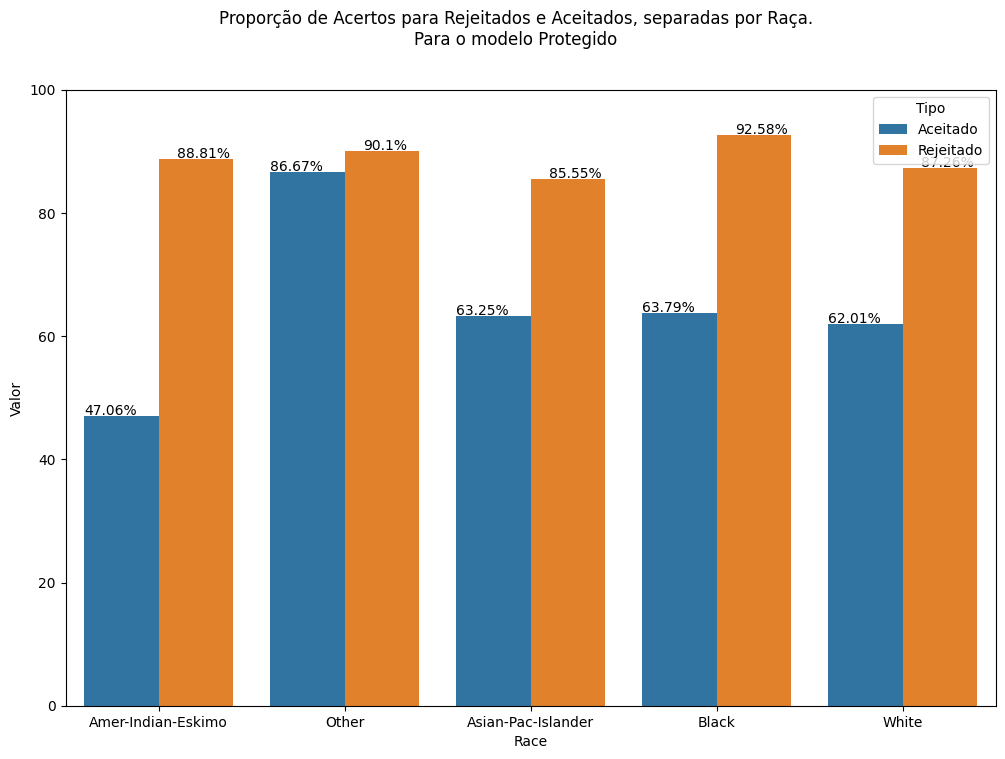

In [134]:
fig2 = plt.figure(figsize = (12, 8))
fig2.suptitle("Proporção de Acertos para Rejeitados e Aceitados, separadas por Raça.\nPara o modelo Protegido")

# plot = sns.barplot(ax2 = ax2[0], data = ,x = "proportion", y = "race", hue = "income")
plot.set_ylabel("Raça")
plot.set_xlabel("Proporção")    

plot2 = sns.barplot(data = tabela, x = "Race", y = "Valor", hue = "Tipo")

for index, row in tabela.iterrows():
    plot2.text((row.name)/2 - 0.4, (row.Valor) + 0.2, str(round(row.Valor, 2)) + "%",color='black')

plt.ylim((0,100))
plt.show()
fig2.savefig("output2.png")

### Restrição de "Predictive Parity"

In [135]:
newdata = pd.DataFrame()
newdata['race'] = raceTest.copy()
newdata['previsao'] = previsaoProtected.copy()
newdata['income'] = num_Y_testProtected.copy()

In [136]:
races = newdata['race'].unique()
tabela1 = pd.DataFrame(columns = ['Race', 'Valor'])

for race in races:
    groupedRaces = (newdata.loc[(newdata['race'] == race)])

    valor = mean_absolute_error(groupedRaces['income'], groupedRaces['previsao'])

    tabela1.loc[-1] = [race, valor]
    tabela1.index = tabela1.index + 1
    tabela1 = tabela1.sort_index()

tabela1['Valor'] = - (tabela1['Valor'] * 100) + 100 

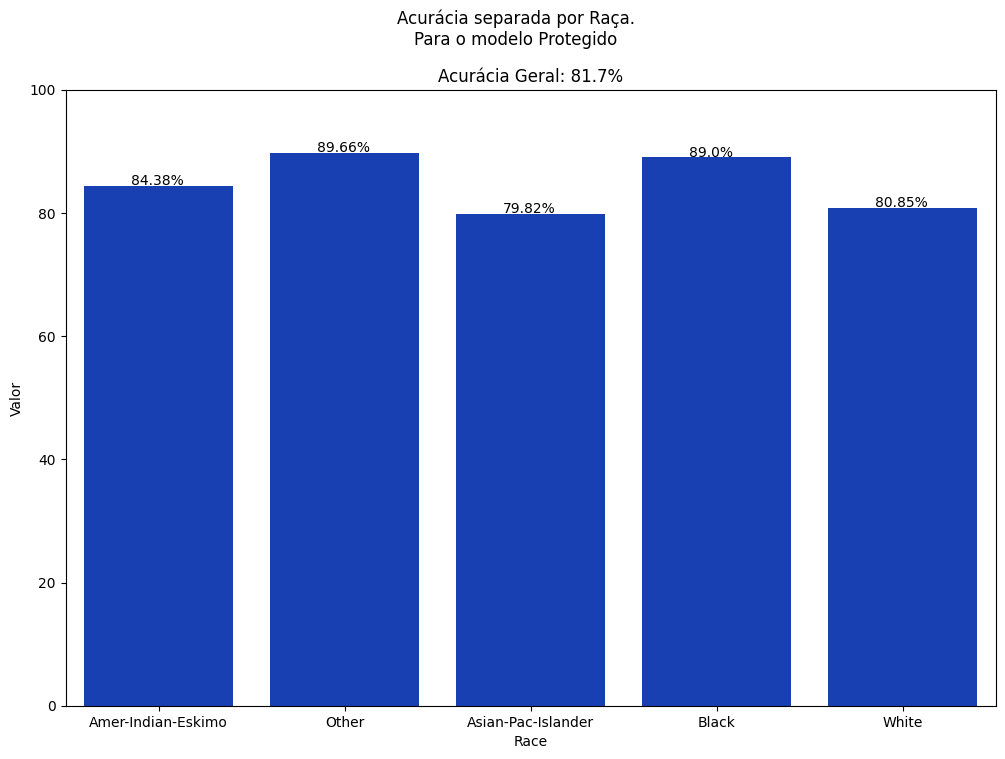

In [137]:
fig3 = plt.figure(figsize = (12, 8))
fig3.suptitle("Acurácia separada por Raça.\nPara o modelo Protegido")

# plot = sns.barplot(ax2 = ax2[0], data = ,x = "proportion", y = "race", hue = "income")
# plot.set_ylabel("Raça")
# plot.set_xlabel("Proporção")    

plot2 = sns.barplot(data = tabela1, x = "Race", y = "Valor", color = "#0033cc")

for index, row in tabela1.iterrows():
    plot2.text((row.name) - 0.15, (row.Valor) + 0.2, str(round(row.Valor, 2)) + "%",color='black')


plt.title("Acurácia Geral: " + str(round(-(acuraciaP * 100) + 100, 2)) + "%")
plt.ylim((0,100))
plt.show()
fig3.savefig("output3.png")

## Conclusão:
Os valores das Proporções, que nesse caso podem ser interpretados como Probabilidades, diferem bastante entre si, tanto no modelo protegido, quanto no não protegido, assim a restrição de Independência, ou Paridade Estatística, não estão sendo atendidas por esses Modelos.

Analisando um pouco mais e fazendo testes retirando e adicionando colunas cheguei a conclusão que é difícil resolver essa desigualdade com métodos verticais, acredito que a melhor forma de tratar isso é com a adição/remoção de tuplas no DataSet, devido à grande desigualdade entre os valores, problema: Como fazer isso sem perder MUITA acurácia. Como não consegui resolver vou continuar pesquisando. Outra possibilidade de resolução, que eu acho improvável mais possível: Utilizar outra restrição de Fairness menos rígida.